# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## Question 1

Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.

### Approach

We will use the same model as in part 2 notebook, but now we will also back propagate
the loss into the word embeddings itself. This will mean that as the model learns,
the word embeddings would also update, causing the encoding of the words to change.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from common_utils import EmbeddingMatrix

In [3]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE


dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [4]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x,_,lenghts, sample_y = next(dataiter)

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)
print()
print('Sample label size: ', lenghts.size()) # batch_size
print('Sample label: \n', lenghts)

Sample input: 
 tensor([[14820, 16164,  6541,  ..., 16163, 16163, 16163],
        [ 6712,  4297,    27,  ..., 16163, 16163, 16163],
        [13575,  4461,    21,  ..., 16163, 16163, 16163],
        ...,
        [16042,  7778,  2215,  ..., 16163, 16163, 16163],
        [14339, 12868,  9793,  ..., 16163, 16163, 16163],
        [10966, 14339,  1483,  ..., 16163, 16163, 16163]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([15, 21, 38, 14,  6, 29, 14,  8, 36, 33, 12, 32, 20, 32, 25, 26, 25, 18,
         9, 29, 25, 10, 20, 16, 30, 31, 19, 35, 42, 16, 33, 16, 26,  9, 12, 26,
        31, 44,  4, 33, 34, 18, 24, 32, 26, 16, 25, 29, 27, 11])


In [29]:
class RNN(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()
        
        # output, _ = self.rnn(embedded, h0)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # print("Output shape: ", output.shape)
        output, _ = torch.max(output, dim=1)
        
        # print("Output shape with max: ", output.shape)
        # print(output)
        
        # if self.dropout_rate > 0:
        #     output = self.dropout(output)
        # # if num_layers > 1, we need to do max pooling
        # if self.num_layers > 1:
        #     output, _ = torch.max(output, 1)
        # else:
        #     output = output[:, -1, :]
        
        out = self.fc(output)  # Use the last output of the RNN for classification
        # print("Output shape with fc: ", out.shape)
        # print(out)
        
        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out

from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


basic_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)


The index of <PAD> is:  16163


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = basic_RNN
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)
epochs = 100
es_patience = 15

In [31]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label).item()

# training
def train_loop(train_loader, model, loss_fn, optimizer, scheduler, max_norm = 5):
    train_loss = []
    train_acc = 0.0
    model.train()
    for X, extra_features, lengths, Y in train_loader:
        X, Y = X.to(device), Y.to(device)   

        optimizer.zero_grad()
        output = model(X, lengths)
        
        # calculate the loss and perform backprop
        loss = loss_fn(output.squeeze(), Y.float())
        train_loss.append(loss.item())
        loss.backward()
        
        # calculating accuracy
        accuracy = acc(output,Y)
        train_acc += accuracy
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
    scheduler.step()
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = train_acc/len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc


def test_loop(test_loader, model, loss_fn):
    test_loss = []
    test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for X,extra_features, lengths, Y in test_loader:
            X, Y = X.to(device), Y.to(device)   

            optimizer.zero_grad()
            output = model(X, lengths)
            
            # calculate the loss and perform backprop
            loss = loss_fn(output.squeeze(), Y.float())

            test_loss.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,Y)
            test_acc += accuracy

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = test_acc/len(test_loader.dataset)

    return epoch_test_loss, epoch_test_acc

best_val_loss = np.inf
best_acc = 0
train_loss_, train_acc_, val_loss_, val_acc_ = [], [], [], []
from tqdm import tqdm
# start training
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    val_loss, val_acc = test_loop(val_loader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= es_patience:
            print(f'early stopping after {epoch+1} epochs')
            print(f'best val loss: {best_val_loss}')
            print(f'best accuracy on val set: {best_acc}')
            break

    if epoch % 10 == 0:
        print(f"epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, val_loss {val_loss:>7f}, val_acc {val_acc:>4f}")

  1%|          | 1/100 [00:01<03:17,  2.00s/it]

epoch 1, train_loss 0.613947 train_acc 0.655686, val_loss 0.527035, val_acc 0.760788


 11%|█         | 11/100 [00:22<02:58,  2.01s/it]

epoch 11, train_loss 0.187221 train_acc 0.932943, val_loss 0.474870, val_acc 0.796435


 18%|█▊        | 18/100 [00:38<02:54,  2.13s/it]

early stopping after 19 epochs
best val loss: 0.4656761735677719
best accuracy on val set: 0.7964352720450282


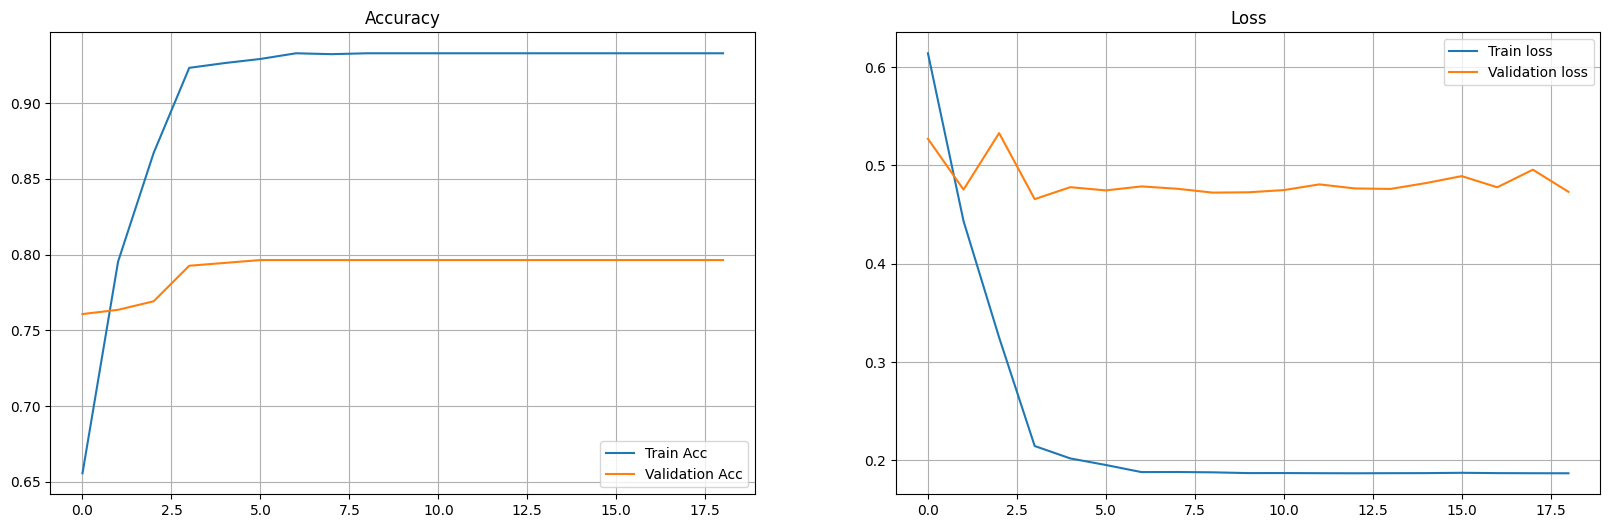

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_, label='Train Acc')
plt.plot(val_acc_, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(train_loss_, label='Train loss')
plt.plot(val_loss_, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [33]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

test_loss 0.429601, test_acc 0.805816


## Question 2

### Approach

As discussed in part 1, we have mentioned 2 approaches to handling of the
OOV words. We will now demonstrate the first approach, which is to replace the OOV
words with a special token. We will replace the OOV words with a special token
`<UNK>`.

In [ ]:
import json
from common_utils import EMBEDDING_DIM, EMBEDDING_MATRIX_PATH, IDX2WORD_PATH, UNK_TOKEN, WORD2IDX_PATH, load_glove_embeddings


w2v_model = EmbeddingMatrix.load()
extended_vocab = w2v_model.vocab
extended_vocab.add(UNK_TOKEN)

glove_dict = load_glove_embeddings()

# Collect words to be removed
missing_words = []
for word in extended_vocab:
    if word not in glove_dict:
        missing_words.append(word)

# Remove missing words from vocab
for word in missing_words:
    extended_vocab.remove(word)
        
print(f"Number of missing words: {len(missing_words)}")
print(f"The missing words are: {missing_words}")

# mapping of words to indices and vice versa
word2idx = {word: idx for idx, word in enumerate(sorted(extended_vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Building embedding matrix...")
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx.items():
    embedding_matrix[idx] = glove_dict[word]

# add random vector for unknown words
embedding_matrix[word2idx[UNK_TOKEN]] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

print("Embedding matrix built successfully.")


For the second approach, we will use the FastText embeddings, which are trained on
subword information. This will help in encoding the OOV words as well.

In [ ]:
# Implementation of FastText for word embedding
import gensim
from gensim.models import FastText
from common_utils import EMBEDDING_DIM
# Create a FastText model with the same dimensions as the Word2Vec model
fasttext_model = FastText(
    vector_size=EMBEDDING_DIM,
    window=5, # context window size 
    min_count=1, # threshold for word frequency
    workers=4
)

In [ ]:
from datasets import load_dataset, Dataset
from common_utils import EmbeddingMatrix, tokenize
import nltk
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']

corpus = []
for example in train_dataset:
    tokens = nltk.word_tokenize(example['text'])
    corpus.append(tokens)
print("The corpus has {} documents.".format(len(corpus)))

In [ ]:
fasttext_model.build_vocab(corpus_iterable=corpus)
# fasttext_model.build_vocab(corpus_iterable=corpus, update=True)

print("Length of vocabulary:", len(fasttext_model.wv.key_to_index))


fasttext_model.train(
    corpus_iterable=corpus, epochs=fasttext_model.epochs,
    total_examples=fasttext_model.corpus_count, total_words=fasttext_model.corpus_total_words,
)

In [ ]:
"computer" in fasttext_model.wv.key_to_index

In [ ]:
fasttext_vocab = set(fasttext_model.wv.key_to_index.keys())
w2v_model = EmbeddingMatrix.load()

In [ ]:
w2v_model.vocab - fasttext_vocab

In [ ]:
fasttext_vocab - w2v_model.vocab

In [ ]:
print("The FastText model has {} words.".format(len(fasttext_model.wv.key_to_index)))
print("The Word2Vec model has {} words.".format(len(w2v_model.vocab)))
print("The FastText model has {} words that are not in the Word2Vec model.".format(len(fasttext_vocab - w2v_model.vocab)))
print("The Word2Vec model has {} words that are not in the FastText model.".format(len(w2v_model.vocab - fasttext_vocab)))

In [ ]:
# save the FastText model
fasttext_model.save("fasttext_model.model")

# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.
